# Adversarial Autoencoders

In [1]:
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras.layers import Input, Dense, Activation, LeakyReLU, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential, Model
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.layers.merge import concatenate, Concatenate

%matplotlib inline


/Users/harshdeep/final3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/harshdeep/final3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/harshdeep/final3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/harshdeep/final3/lib/python3.7/site-packages/tensorflow/python/framework

### Parameters and hyperparameters
rows, columns and channels dictate the properties of the input image
latent_size is the size of the "squished" or encoded representation
optimizer is just the optimizer
epochs & batch_size are just training hyperparameters

In [2]:
# just some variables

rows = 28
cols = 28
channels = 1
img_shape = (rows, cols, channels)
img_size = rows * cols * channels

latent_size = 2
disc_latent_size = 12
epochs = 5000
batch_size = 64


In [3]:
# create the encoder
def create_encoder(latent_size, img_size):
    model = Sequential()
    model.add(Dense(512, input_dim=img_size))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(latent_size))

    in_img = Input(shape=(img_size,))
    encoded_repr = model(in_img)

    return Model(in_img, encoded_repr)

In [4]:
# create the decoder
def create_decoder(latent_size, img_size):
    model = Sequential()
    model.add(Dense(512, input_dim=latent_size))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(img_size, activation='sigmoid'))

    encoded_repr = Input(shape=(latent_size,))
    out_img = model(encoded_repr)

    return Model(encoded_repr, out_img)

## Discriminator
This is the main part of *adversarial* autoencoders. The discriminator first learns how to tell whether an array belongs to a given distribution. The encoder then uses the discriminators output to try to make the encoded representation fit the given latent space.

In [5]:
# create the discriminator
def create_discriminator(disc_latent_size):
    model = Sequential()
    model.add(Dense(256, input_dim=disc_latent_size))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    encoded_repr = Input(shape=(latent_size,), name='z_latent')
    label_ss = Input(shape=(disc_latent_size-latent_size,), name='labeled_input')
    concatenated_disc_input = concatenate([encoded_repr, label_ss])
    probability = model(concatenated_disc_input)

    return Model([encoded_repr, label_ss], probability)

In [6]:
# putting it together

discriminator = create_discriminator(disc_latent_size)
discriminator.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

encoder = create_encoder(latent_size, img_size)
decoder = create_decoder(latent_size, img_size)

img = Input(shape=(img_size,))

encoded_repr = encoder(img)

decoded = decoder(encoded_repr)

discriminator.trainable = False

disc_input = Input(shape=(disc_latent_size-latent_size,))

validity = discriminator([encoded_repr, disc_input])

adversarial = Model([img, disc_input], [decoded, validity])
adversarial.compile(loss=['mse', 'binary_crossentropy'], 
                          loss_weights=[0.999, 0.001], 
                          optimizer='adam')

W0902 18:16:48.231866 4651271616 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0902 18:16:48.255428 4651271616 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0902 18:16:48.259305 4651271616 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0902 18:16:48.330937 4651271616 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0902 18:16:48.362938 46

In [7]:
# get and preprocess data

(x_train, x_test), (y_train, y_test) = mnist.load_data()

x_train = x_train.astype(np.float64) / 255

x_train = x_train.reshape(x_train.shape[0], img_size)

training = x_train.reshape((len(x_train), 28, 28, 1))


y_train = y_train.astype(np.float64) / 255

y_train = y_train.reshape(y_train.shape[0], img_size)

testing = y_train.reshape((len(y_train), 28, 28, 1))

In [8]:
# create real and fake
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
    ohe_vector_valid = np.zeros((batch_size, 10))
    ohe_vector_fake = np.zeros((batch_size, 10))
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]
    labels = x_test[idx]
    
    for l in range(len(labels)):
        ohe_vector_valid[l][labels[l]] = 1
    
    for l in range(batch_size):
        ohe_vector_fake[l][9] = 1
        
    latent_fake = encoder.predict(imgs)
    latent_real = np.random.normal(size=(batch_size, latent_size))
    
#     latent_fake = np.hstack((latent_fake, ohe_vector_valid))
#     latent_real = np.hstack((latent_real, ohe_vector_fake))
    
    d_data = np.vstack((latent_fake, latent_real))
    d_actual_label = np.vstack((ohe_vector_valid, ohe_vector_fake))
    
    d_label = np.vstack((fake,valid))
    # Train the discriminator
    d_loss = discriminator.train_on_batch([d_data, d_actual_label], d_label)
#     d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
#     d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#     print(imgs.shape, d_data.shape)

    g_loss = adversarial.train_on_batch([imgs, d_actual_label[:64]], [imgs, valid])

#     # Plot the progress (every 10th epoch)
    if epoch % 10 == 0:
        print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (
            epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

W0902 18:16:54.426724 4651271616 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3005: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

/Users/harshdeep/final3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.695333, acc: 54.69%] [G loss: 0.231604, mse: 0.231125]
10 [D loss: 0.170110, acc: 96.09%] [G loss: 0.092447, mse: 0.077179]
20 [D loss: 0.026693, acc: 100.00%] [G loss: 0.091753, mse: 0.078408]
30 [D loss: 0.054203, acc: 98.44%] [G loss: 0.076075, mse: 0.069545]
40 [D loss: 0.138049, acc: 96.09%] [G loss: 0.074721, mse: 0.069397]
50 [D loss: 0.228227, acc: 91.41%] [G loss: 0.079002, mse: 0.068791]
60 [D loss: 0.260737, acc: 89.84%] [G loss: 0.079879, mse: 0.067298]
70 [D loss: 0.529870, acc: 85.16%] [G loss: 0.077442, mse: 0.066866]
80 [D loss: 2.638911, acc: 57.81%] [G loss: 0.076177, mse: 0.069871]
90 [D loss: 0.724414, acc: 82.81%] [G loss: 0.083470, mse: 0.068488]
100 [D loss: 2.127877, acc: 67.97%] [G loss: 0.081416, mse: 0.071235]
110 [D loss: 2.404180, acc: 35.94%] [G loss: 0.089648, mse: 0.078738]
120 [D loss: 1.043375, acc: 64.06%] [G loss: 0.094304, mse: 0.078898]
130 [D loss: 0.539087, acc: 76.56%] [G loss: 0.086662, mse: 0.072421]
140 [D loss: 0.390892, acc: 89

1170 [D loss: 0.160668, acc: 94.53%] [G loss: 0.054278, mse: 0.047557]
1180 [D loss: 0.142947, acc: 95.31%] [G loss: 0.055551, mse: 0.048719]
1190 [D loss: 0.161483, acc: 93.75%] [G loss: 0.055202, mse: 0.048372]
1200 [D loss: 0.095802, acc: 97.66%] [G loss: 0.057638, mse: 0.050430]
1210 [D loss: 0.118175, acc: 96.88%] [G loss: 0.056527, mse: 0.049450]
1220 [D loss: 0.181720, acc: 92.97%] [G loss: 0.056239, mse: 0.049643]
1230 [D loss: 0.217985, acc: 92.19%] [G loss: 0.055199, mse: 0.048692]
1240 [D loss: 0.173135, acc: 93.75%] [G loss: 0.055409, mse: 0.048628]
1250 [D loss: 0.229591, acc: 91.41%] [G loss: 0.055553, mse: 0.049298]
1260 [D loss: 0.117116, acc: 96.88%] [G loss: 0.057618, mse: 0.050417]
1270 [D loss: 0.145889, acc: 95.31%] [G loss: 0.052040, mse: 0.045007]
1280 [D loss: 0.150939, acc: 95.31%] [G loss: 0.053658, mse: 0.046659]
1290 [D loss: 0.132273, acc: 96.09%] [G loss: 0.054189, mse: 0.046949]
1300 [D loss: 0.123598, acc: 96.09%] [G loss: 0.058045, mse: 0.050975]
1310 [

2330 [D loss: 0.156349, acc: 94.53%] [G loss: 0.057482, mse: 0.049153]
2340 [D loss: 0.060477, acc: 99.22%] [G loss: 0.055200, mse: 0.045970]
2350 [D loss: 0.172618, acc: 93.75%] [G loss: 0.051520, mse: 0.043312]
2360 [D loss: 0.113554, acc: 96.09%] [G loss: 0.054767, mse: 0.046094]
2370 [D loss: 0.091262, acc: 96.88%] [G loss: 0.054512, mse: 0.045596]
2380 [D loss: 0.089227, acc: 97.66%] [G loss: 0.058397, mse: 0.049371]
2390 [D loss: 0.091552, acc: 96.09%] [G loss: 0.054446, mse: 0.045706]
2400 [D loss: 0.103672, acc: 96.88%] [G loss: 0.052338, mse: 0.043504]
2410 [D loss: 0.124453, acc: 93.75%] [G loss: 0.056721, mse: 0.048444]
2420 [D loss: 0.128311, acc: 95.31%] [G loss: 0.052068, mse: 0.043651]
2430 [D loss: 0.140246, acc: 94.53%] [G loss: 0.053953, mse: 0.045515]
2440 [D loss: 0.097307, acc: 95.31%] [G loss: 0.055992, mse: 0.047293]
2450 [D loss: 0.069266, acc: 98.44%] [G loss: 0.054615, mse: 0.045147]
2460 [D loss: 0.141967, acc: 93.75%] [G loss: 0.054671, mse: 0.046227]
2470 [

3490 [D loss: 0.113131, acc: 93.75%] [G loss: 0.059389, mse: 0.047702]
3500 [D loss: 0.092861, acc: 93.75%] [G loss: 0.053177, mse: 0.041363]
3510 [D loss: 0.103441, acc: 94.53%] [G loss: 0.054710, mse: 0.043232]
3520 [D loss: 0.088905, acc: 96.09%] [G loss: 0.053264, mse: 0.041499]
3530 [D loss: 0.101383, acc: 96.09%] [G loss: 0.054467, mse: 0.042945]
3540 [D loss: 0.062491, acc: 97.66%] [G loss: 0.051938, mse: 0.040075]
3550 [D loss: 0.091428, acc: 95.31%] [G loss: 0.053869, mse: 0.042564]
3560 [D loss: 0.095364, acc: 96.09%] [G loss: 0.052617, mse: 0.041254]
3570 [D loss: 0.086953, acc: 93.75%] [G loss: 0.054892, mse: 0.042935]
3580 [D loss: 0.121312, acc: 94.53%] [G loss: 0.052862, mse: 0.042062]
3590 [D loss: 0.068690, acc: 96.88%] [G loss: 0.058193, mse: 0.046062]
3600 [D loss: 0.082269, acc: 93.75%] [G loss: 0.052317, mse: 0.041115]
3610 [D loss: 0.112298, acc: 94.53%] [G loss: 0.058495, mse: 0.047083]
3620 [D loss: 0.062944, acc: 96.09%] [G loss: 0.056968, mse: 0.045200]
3630 [

4650 [D loss: 0.047292, acc: 98.44%] [G loss: 0.059821, mse: 0.046623]
4660 [D loss: 0.111800, acc: 96.88%] [G loss: 0.053171, mse: 0.040526]
4670 [D loss: 0.024692, acc: 100.00%] [G loss: 0.060614, mse: 0.047486]
4680 [D loss: 0.056811, acc: 98.44%] [G loss: 0.059139, mse: 0.046159]
4690 [D loss: 0.066981, acc: 95.31%] [G loss: 0.050505, mse: 0.038083]
4700 [D loss: 0.015023, acc: 100.00%] [G loss: 0.059855, mse: 0.047011]
4710 [D loss: 0.047417, acc: 97.66%] [G loss: 0.054393, mse: 0.041666]
4720 [D loss: 0.116684, acc: 93.75%] [G loss: 0.053722, mse: 0.041386]
4730 [D loss: 0.078184, acc: 93.75%] [G loss: 0.050957, mse: 0.038729]
4740 [D loss: 0.035722, acc: 99.22%] [G loss: 0.052087, mse: 0.039084]
4750 [D loss: 0.047346, acc: 96.88%] [G loss: 0.052725, mse: 0.039760]
4760 [D loss: 0.021302, acc: 99.22%] [G loss: 0.060270, mse: 0.047465]
4770 [D loss: 0.209989, acc: 94.53%] [G loss: 0.050612, mse: 0.038140]
4780 [D loss: 0.091968, acc: 96.09%] [G loss: 0.057467, mse: 0.044348]
4790

Ideally the accuracy of the discriminator would be ~50% (due to just guessing) but its not perfect

## Sampling latent space & reconstructions

In [15]:
# Sample images

def sample_latents():
#     fig = plt.figure(figsize=(9,13))
#     columns = 4
#     rows = 5
    
#     zs = np.random.normal(size=(columns*rows +1, latent_size))
#     decoded = decoder.predict(zs)
    
#     for i in range(1,columns*rows + 1):
#         fig.add_subplot(rows,columns,i)
#         img = decoded[i].reshape(28, 28)
#         plt.imshow(img, cmap="gray")
        
#     plt.show()
    x_test_encoded = encoder.predict(y_train, batch_size=128)
    plt.figure(figsize=(20,10))
    plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test)
    plt.colorbar()
    plt.show()
        
    
    
    
def sample_reconstructions():
    fig = plt.figure(figsize=(9,13))
    columns = 4
    rows = 5
    
    ohe_vector_valid = np.zeros((batch_size, 10))
    ohe_vector_fake = np.zeros((batch_size, 10))
    
    idx = np.random.randint(0, x_train.shape[0], 10)
    imgs = x_train[idx]
    labels = x_test[idx]
    
    for l in range(len(labels)):
        ohe_vector_valid[l][labels[l]] = 1
    
    for l in range(batch_size):
        ohe_vector_fake[l][9] = 1
    d_actual_label = np.vstack((ohe_vector_valid, ohe_vector_fake))
    reconstructions = adversarial.predict([imgs, d_actual_label])[0]
    
    for i in range(0, columns*rows,2):
        fig.add_subplot(rows,columns,i+1)
        img1 = imgs[i//2].reshape(28,28)
        plt.imshow(img1,cmap="gray")
        fig.add_subplot(rows,columns,i+2)
        img2 = reconstructions[i//2].reshape(28,28)
        plt.imshow(img2,cmap="gray")

    plt.show()

## Visualising gaussian examples
The model is not that great at transforming latent samples into images and its easy to see its flaws as most of the images are not very clear

One observation is that as you reduce the bottleneck of the network, the gaussian examples are much clearer but the reconstructions suffer. This is probably because the less features, the more likely the selected example is closer to a real image.

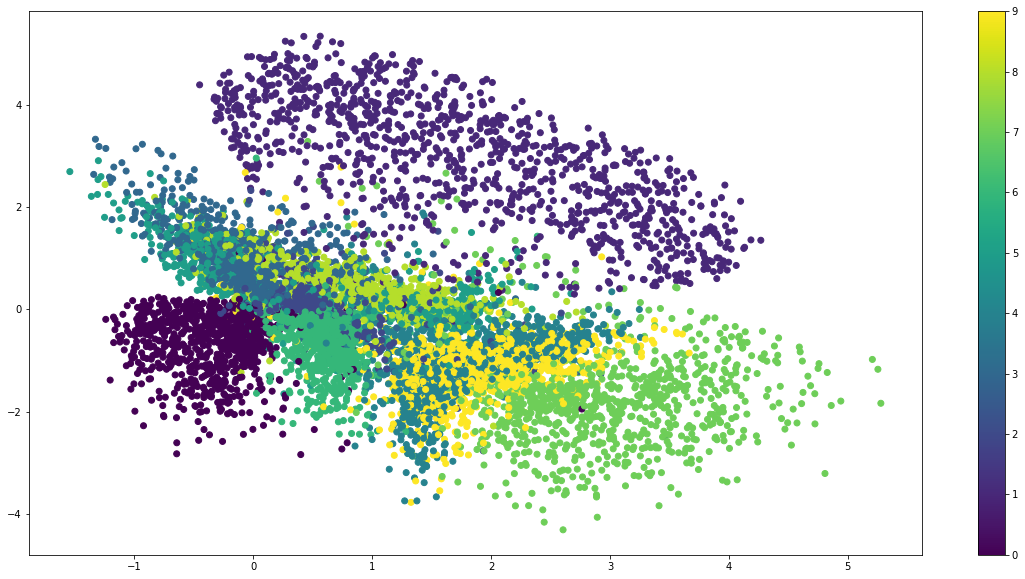

In [16]:
sample_latents()

## Visualising Reconstruction
The reconstruction turned out to be pretty good and it is pretty easy to distinguish the reconstructed image

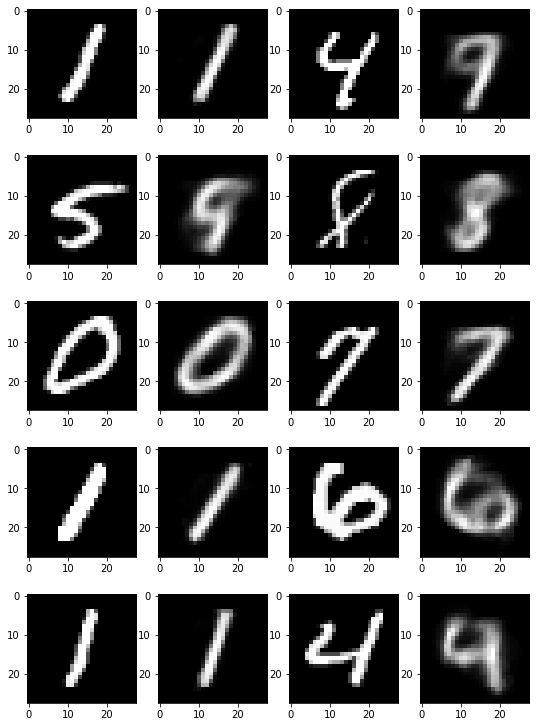

In [17]:
sample_reconstructions()